In [1]:
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

sys.path.append("..")
from baseline_models.temporal.pytorch.optimizer import Optimizer
from baseline_models.temporal.pytorch.utils import *

sys.path.append("../..")
from cyclops.feature_handler import FeatureHandler

In [2]:
DIR = "/mnt/nfs/project/delirium/drift_exp/MAY-31-2022/"
feature_handler = FeatureHandler()
feature_handler.load(DIR, "test_features")

2022-06-07 18:28:15,278 INFO cyclops.feature_handler - Loading features from file...
2022-06-07 18:28:15,282 INFO cyclops.feature_handler - Found file to load for static features...
2022-06-07 18:28:15,284 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-06-07 18:28:15,381 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-06-07 18:28:15,532 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


In [3]:
ref_static = feature_handler.reference["static"]

In [4]:
static = feature_handler.features["static"]
print("Encounters:", static.shape[0])
print("Static Features:", static.shape[1])

Encounters: 5064
Static Features: 25


In [5]:
outcome = "mortality"
# static = process_outcome(outcome, static)

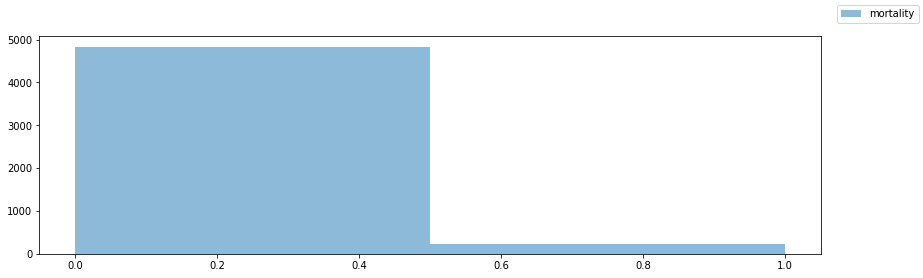

In [6]:
fig, ax = plt.subplots(figsize=(14, 4))
plt.hist(static["mortality"], bins=2, alpha=0.5, width=0.5, label="mortality")
fig.legend(loc="upper right")
plt.show()

In [7]:
ref_temporal = feature_handler.reference["temporal"]

In [8]:
temporal = feature_handler.features["temporal"]
samples = len(temporal.index.unique(level=0))
timesteps = len(temporal.index.unique(level=1))
features = temporal.shape[1]
print("Encounters:", samples)
print("Timesteps:", timesteps)
print("Temporal Features:", features)

Encounters: 4613
Timesteps: 8
Temporal Features: 12


In [9]:
temporal = temporal.rename_axis("features", axis="columns")

In [18]:
output_dim = 1
batch_size = 1
input_dim = features * 3
hidden_dim = 256
layer_dim = 1
dropout = 0.2
n_epochs = 5
learning_rate = 1e-3
weight_decay = 1e-6
last_timestep_only = True

device = get_device()

X = temporal[
    np.in1d(temporal.index.get_level_values(0), static.index.get_level_values(0))
]
y = static[np.in1d(static.index.get_level_values(0), X.index.get_level_values(0))]
y_train, y_val = train_test_split(y, test_size=1 / 2)
y_val, y_test = train_test_split(y_val, test_size=1 / 2)
X_train = X[np.in1d(X.index.get_level_values(0), y_train.index.get_level_values(0))]
X_train_inputs = format_dataset(X_train, level="features", imputation_method="simple")
X_val = X[np.in1d(X.index.get_level_values(0), y_val.index.get_level_values(0))]
X_val_inputs = format_dataset(X_val, level="features", imputation_method="simple")
X_test = X[np.in1d(X.index.get_level_values(0), y_test.index.get_level_values(0))]
X_test_inputs = format_dataset(X_test, level="features", imputation_method="simple")

if last_timestep_only:
    timesteps = -1
    y_train = y_train[[outcome]].to_numpy()
    y_val = y_val[[outcome]].to_numpy()
    y_test = y_test[[outcome]].to_numpy()
else:
    y_train = np.repeat(y_train[[outcome]].to_numpy(), timesteps).reshape(
        len(X_train.index.unique(level=0)), timesteps, 1
    )
    y_val = np.repeat(y_val[[outcome]].to_numpy(), timesteps).reshape(
        len(X_val.index.unique(level=0)), timesteps, 1
    )
    y_test = np.repeat(y_test[[outcome]].to_numpy(), timesteps).reshape(
        len(X_test.index.unique(level=0)), timesteps, 1
    )

train_dataset = get_data(X_train_inputs, y_train)
train_loader = train_dataset.to_loader(batch_size, shuffle=True)

val_dataset = get_data(X_val_inputs, y_val)
val_loader = val_dataset.to_loader(batch_size)

/mnt/nfs/home/subasriv/cyclops/drift_detection/notebooks/../baseline_models/temporal/pytorch/utils.py:98: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  output=np.dstack((X.loc[(slice(None), i), :].values for i in sorted(set(timestep_in_values))))
/mnt/nfs/home/subasriv/cyclops/drift_detection/notebooks/../baseline_models/temporal/pytorch/utils.py:98: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  output=np.dstack((X.loc[(slice(None), i), :].values for i in sorted(set(timestep_in_values))))
/mnt/nfs/home/subasriv/cyclops/drift_detection/notebooks/../baseline_models/temporal/pytorch/utils.py:98: FutureWarning: arrays to stack must be passed as a "sequence

In [19]:
model_params = {
    "device": device,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "layer_dim": layer_dim,
    "output_dim": output_dim,
    "dropout_prob": dropout,
    "last_timestep_only": last_timestep_only,
}

model = get_temporal_model("lstm", model_params).to(device)

/mnt/nfs/home/subasriv/.cache/pypoetry/virtualenvs/cyclops-KKtuQLwg-py3.9/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/5] Training loss: 0.7186	 Validation loss: 0.7213
[2/5] Training loss: 0.7184	 Validation loss: 0.7212
[3/5] Training loss: 0.7183	 Validation loss: 0.7211
[4/5] Training loss: 0.7183	 Validation loss: 0.7210
[5/5] Training loss: 0.7182	 Validation loss: 0.7210


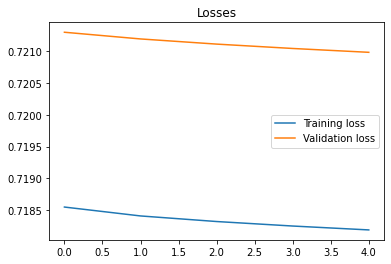

In [20]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adagrad(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)
activation = nn.Sigmoid()
opt = Optimizer(
    model=model, loss_fn=loss_fn, optimizer=optimizer, activation=activation
)
opt.train(
    train_loader,
    val_loader,
    batch_size=batch_size,
    n_epochs=n_epochs,
    n_features=input_dim,
    timesteps=timesteps,
)
opt.plot_losses()

In [22]:
test_dataset = get_data(X_test_inputs, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
    test_loader, batch_size=1, n_features=input_dim, timesteps=timesteps
)

pred_metrics = print_metrics_binary(y_test_labels, y_pred_values, y_pred_labels)
pred_metrics
df_result = format_predictions(
    y_pred_labels, y_test_labels, y_pred_labels, X_test, last_timestep_only
)
df_result

confusion matrix:
[[  36 1061]
 [   1   56]]
accuracy = 0.07972270250320435
precision class 0 = 0.9729729890823364
precision class 1 = 0.050134290009737015
recall class 0 = 0.032816771417856216
recall class 1 = 0.9824561476707458
AUC of ROC = 0.4564761950454989
AUC of PRC = 0.0414908523854454
min(+P, Se) = 0.054276315789473686


,y_pred_values,y_test_labels,y_pred_labels
encounter_id,,,
11100097,1.0,0.0,1.0
11100782,1.0,0.0,1.0
11101350,1.0,0.0,1.0
11103407,1.0,0.0,1.0
11103415,1.0,0.0,1.0
...,...,...,...
11997896,1.0,0.0,1.0
11998290,1.0,0.0,1.0
11998426,1.0,0.0,1.0


In [23]:
y_train_labels, y_pred_values, y_pred_labels = opt.evaluate(
    train_loader, batch_size=1, n_features=input_dim, timesteps=timesteps
)
pred_metrics = print_metrics_binary(
    y_train_labels, y_pred_values, y_pred_labels, last_timestep_only
)
pred_metrics

confusion matrix:
[[  79 2125]
 [   6   96]]
accuracy = 0.0758889839053154
precision class 0 = 0.929411768913269
precision class 1 = 0.04322377219796181
recall class 0 = 0.03584391996264458
recall class 1 = 0.9411764740943909
AUC of ROC = 0.41557239955873454
AUC of PRC = 0.03872319326183109
min(+P, Se) = 0.058823529411764705


{'acc': 0.075888984,
 'prec0': 0.92941177,
 'prec1': 0.043223772,
 'rec0': 0.03584392,
 'rec1': 0.9411765,
 'auroc': 0.41557239955873454,
 'auprc': 0.03872319326183109,
 'minpse': 0.058823529411764705}